In [179]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [155]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [156]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

# Load dataset from library

In [157]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [158]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [159]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Divide into trained and unknown classes

In [160]:
CLASS_NUMBER = 10
KEEP_CLASS_NUMBER = 8

keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train.flatten(), keep_classes)
test_keep_mask = np.isin(y_test.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train.flatten(), other_classes)
test_unknown_mask = np.isin(y_test.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test[test_unknown_mask]

In [161]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({6: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 3: 5000, 5: 5000, 0: 5000})
Test labels and counts: Counter({3: 1000, 0: 1000, 6: 1000, 1: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})
Unknown train labels and counts: Counter({9: 5000, 8: 5000})
Unknown test labels and counts: Counter({8: 1000, 9: 1000})


# Plot class distribution

In [162]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

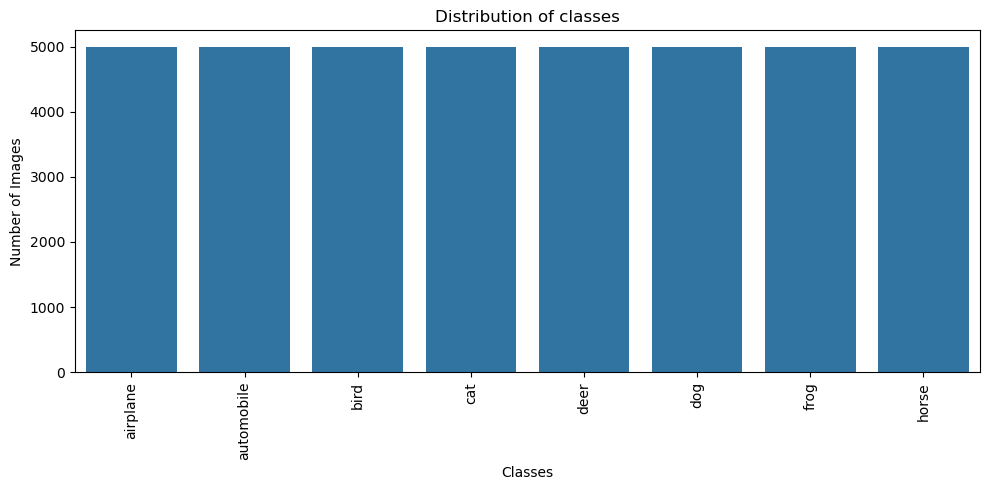

In [163]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

In [164]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

## Known classes

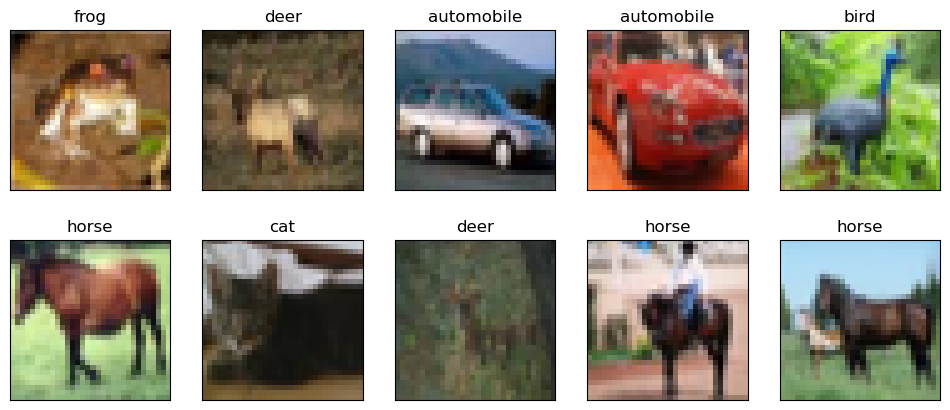

In [165]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

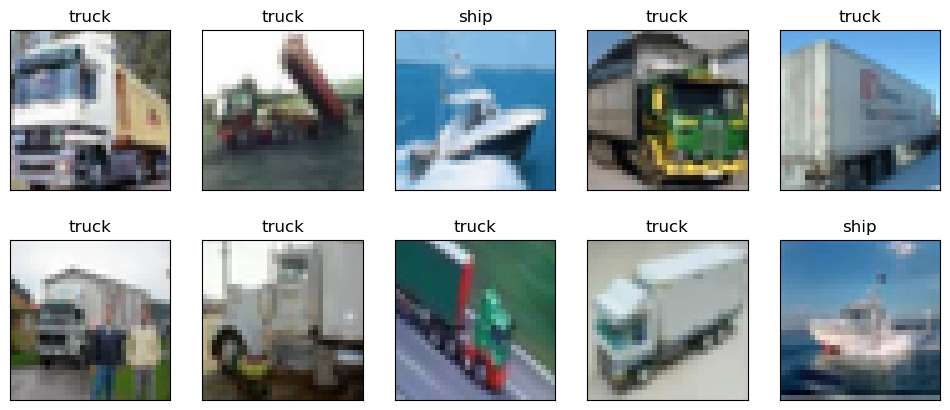

In [166]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [180]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

In [215]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [216]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=256,
    shuffle=False
)

# Train model

# Pre-trained model

In [272]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [273]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Logits
logits = tf.keras.layers.Dense(KEEP_CLASS_NUMBER)(x)

# Probabilities
outputs = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

In [274]:
model_up_to_logits = tf.keras.Model(inputs=pretrained_model.input, outputs=logits)

## Compile model

In [275]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [276]:
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
125/125 [==============================] - 57s 433ms/step - loss: 1.4647 - accuracy: 0.5107 - val_loss: 1.0477 - val_accuracy: 0.6350
Epoch 2/20
125/125 [==============================] - 51s 405ms/step - loss: 1.0978 - accuracy: 0.6162 - val_loss: 0.9707 - val_accuracy: 0.6639
Epoch 3/20
125/125 [==============================] - 51s 411ms/step - loss: 0.9949 - accuracy: 0.6522 - val_loss: 0.9461 - val_accuracy: 0.6729
Epoch 4/20
125/125 [==============================] - 54s 433ms/step - loss: 0.9219 - accuracy: 0.6743 - val_loss: 0.9156 - val_accuracy: 0.6815
Epoch 5/20
125/125 [==============================] - 57s 454ms/step - loss: 0.8553 - accuracy: 0.6976 - val_loss: 0.9045 - val_accuracy: 0.6859
Epoch 6/20
125/125 [==============================] - 61s 489ms/step - loss: 0.8046 - accuracy: 0.7112 - val_loss: 0.8908 - val_accuracy: 0.6905
Epoch 7/20
125/125 [==============================] - 62s 493ms/step - loss: 0.7547 - accuracy: 0.7297 - val_loss: 0.8906 - val_ac

# Extract features using our model up to logits

### Contruct dataset with some outliers

In [303]:
X_unknown_subset = X_train_unknown[:1500]
y_unknown_subset = y_train_unknown[:1500]

X_combined = np.concatenate([X_train_filtered, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_train_filtered, y_unknown_subset], axis=0)

In [304]:
subset_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=False, seed=SEED)

In [305]:
features = model_up_to_logits.predict(subset_flow, verbose=1)

163/163 [==============================] - 53s 327ms/step


In [306]:
features.shape

(41500, 8)

# Isolation forest to detect outliers

In [312]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=SEED
)

# Fit the model
iso_forest.fit(features)

# Predict anomalies (-1 = outlier, 1 = inlier)
predictions = iso_forest.predict(features)

# Get anomaly scores (the lower, the more anomalous)
anomaly_scores = iso_forest.decision_function(features)

In [313]:
mask_inliers = predictions == 1
X_clean = features[mask_inliers]
X_clean.shape

(39425, 8)

In [318]:
outlier_indices = np.where(predictions == -1)[0]

# Select only the outliers from the original arrays
X_outliers = X_combined[outlier_indices]
y_outliers = y_combined[outlier_indices]
scores = anomaly_scores[outlier_indices]

In [320]:
df_outliers = pd.DataFrame({
    'label': y_outliers.flatten(),
    'score': scores
})

# Group by label and compute mean score
avg_scores_per_class = df_outliers.groupby('label')['score'].mean()
print(avg_scores_per_class)

label
0   -0.033040
1   -0.031521
2   -0.030400
3   -0.030575
4   -0.028857
5   -0.050272
6   -0.042172
7   -0.042895
8   -0.029715
9   -0.026734
Name: score, dtype: float64


### Outlier stats

In [315]:
counter = get_class_summary(y_outliers)
for class_index, count in counter.items():
    print(f"{class_names[class_index]}: {count}")

horse: 386
automobile: 338
frog: 244
airplane: 273
dog: 407
bird: 210
cat: 113
deer: 85
truck: 6
ship: 13


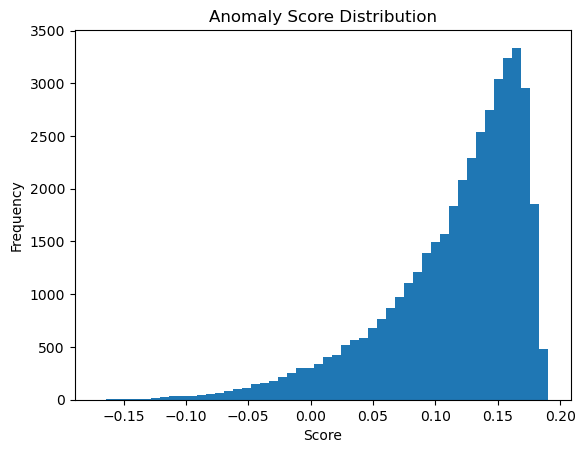

In [316]:
import matplotlib.pyplot as plt

plt.hist(anomaly_scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()